In [1]:
# standard libraries
import pandas as pd
import numpy as np

# visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# tensorflow
import tensorflow as tf
import tensorflow_decision_forests as tfdf
from tensorflow import keras

# scikit-learn
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

pd.set_option('display.max_columns', None)

# Set custom styles for text color
plt.rcParams['text.color'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['axes.titlecolor'] = 'white'
plt.rcParams['xtick.color'] = 'white'  # Color of the x-axis tick values
plt.rcParams['ytick.color'] = 'white'  # Color of the y-axis tick values

train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
submission = pd.read_csv('data/sample_submission.csv')

2023-09-24 15:22:36.503583: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [4]:
test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


In [6]:
submission.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,False


In [7]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   PassengerId  4277 non-null   object
 1   Transported  4277 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 37.7+ KB


In [8]:
target = train.columns.to_list()[-1]
# convert target from bool to int
train[target] = train[target].astype(int)
train_target = train[target]

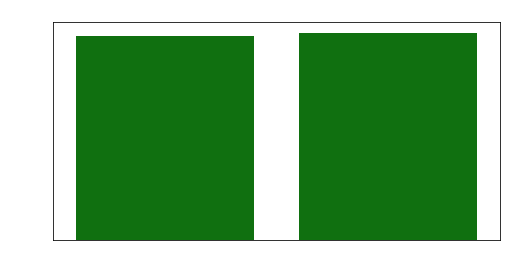

In [9]:
plt.figure(figsize=(8,4))
sns.countplot(data = train, x = target, color='g')
plt.title('Class distribution')
plt.show()

In [10]:
train.drop(target, axis=1, inplace=True)
train_id = train['PassengerId']
test_id = test['PassengerId']

In [11]:
# combine over rows, keeping id for now as group number might be useful
combined = pd.concat([train, test], axis = 0)

### Feature engineering

In [12]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12970 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   12970 non-null  object 
 1   HomePlanet    12682 non-null  object 
 2   CryoSleep     12660 non-null  object 
 3   Cabin         12671 non-null  object 
 4   Destination   12696 non-null  object 
 5   Age           12700 non-null  float64
 6   VIP           12674 non-null  object 
 7   RoomService   12707 non-null  float64
 8   FoodCourt     12681 non-null  float64
 9   ShoppingMall  12664 non-null  float64
 10  Spa           12686 non-null  float64
 11  VRDeck        12702 non-null  float64
 12  Name          12676 non-null  object 
dtypes: float64(6), object(7)
memory usage: 1.4+ MB


In [13]:
combined.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines


In [14]:
combined['Group'] = combined['PassengerId'].str[:4]
combined.drop('PassengerId', inplace=True, axis=1)

Categorical columns

In [15]:
# categorical columns
col_cat_NA = ['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP']

# fill with Group first
for col in col_cat_NA:
    combined[col] = combined.groupby('Group')[col].transform(
    lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))
    
# need to do this, so we can use homeplanet to fill values for destination
combined['HomePlanet'].fillna('', inplace=True)
combined['Destination'] = combined.groupby('HomePlanet')['Destination'].transform(
    lambda x: x.fillna(x.mode()[0]))
# reverse what we did earlier
combined['HomePlanet'].replace('', np.nan, inplace=True)

# now fill homeplanet with destination
combined['HomePlanet'] = combined.groupby('Destination')['HomePlanet'].transform(
    lambda x: x.fillna(x.mode()[0]))

combined['CryoSleep'] = combined.groupby('Destination')['CryoSleep'].transform(
    lambda x: x.fillna(x.mode()[0]))
combined['VIP'].fillna(False, inplace=True)
    
# need to break cabin down, this is screwing it up when the entire cabin isn't available
combined[['deck', 'cabin_num', 'side']] = combined['Cabin'].str.split('/', expand=True)

combined.drop('Cabin', inplace=True, axis=1)

col_cat_na = ['deck', 'cabin_num', 'side']

for col in col_cat_na:
    combined[col] = combined.groupby('Destination')[col].transform(
        lambda x: x.fillna(x.mode()[0]))
combined['cabin_num'] = combined['cabin_num'].astype(int)

# drop name
combined.drop('Name', inplace=True, axis=1)

Numerical columns

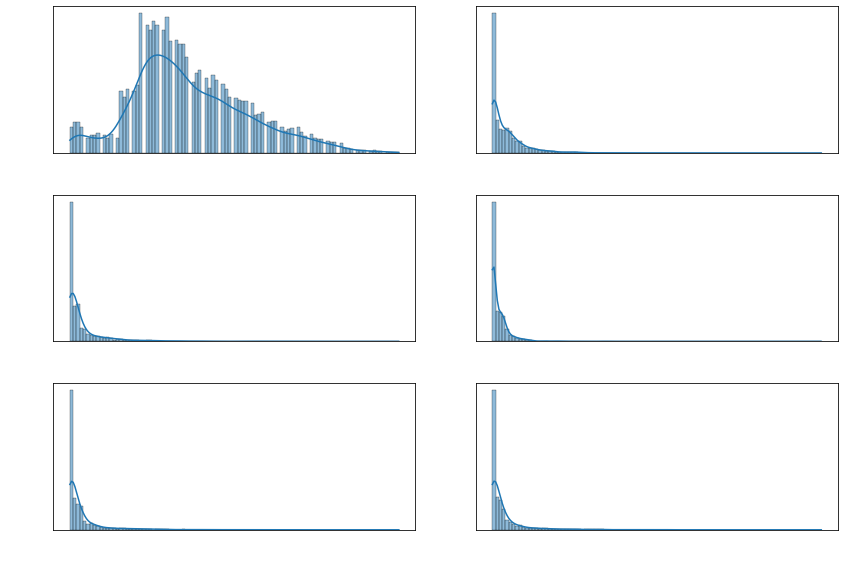

In [16]:
# numerical columns 
col_num = combined.select_dtypes(include=['number']).columns
col_num = col_num.drop(['cabin_num', 'CryoSleep'])

# subplot placehodlers
fig, axes = plt.subplots(3, 2, figsize=(12,8))

# flatten the axes for easier indexing
axes = axes.ravel()

# iterate over number columns, enumerate cause working with index list
for i, col in enumerate(col_num):
    ax = axes[i]
    # checking distribution for data above 0
    t = combined.loc[combined[col]>0]
    sns.histplot(t[col], ax=ax, kde=True, bins=100)
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')
    
# adjust layout
plt.tight_layout()

plt.show()

In [17]:
display(combined.loc[combined['RoomService']>0].describe())
display(combined.loc[combined['RoomService']>0].median())

,CryoSleep,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,cabin_num
count,4404.000000,4321.000000,4404.000000,4296.000000,4303.000000,4304.000000,4322.000000,4404.000000
mean,0.004087,31.032631,643.134196,484.818203,313.019986,365.609433,337.559695,645.533606
std,0.063808,12.431650,969.486624,1477.621759,657.312688,1118.498526,1187.149866,536.059777
min,0.000000,13.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,21.000000,37.000000,0.000000,0.000000,0.000000,0.000000,193.000000
50%,0.000000,28.000000,313.500000,2.000000,19.000000,6.000000,1.000000,471.000000
75%,0.000000,38.000000,857.000000,276.000000,372.000000,245.000000,171.000000,1070.250000
max,1.000000,79.000000,14327.000000,26830.000000,8098.000000,22408.000000,24133.000000,1894.000000


/var/folders/3s/l2m1db5135751grhtk16_j200000gn/T/ipykernel_20543/3600371989.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  display(combined.loc[combined['RoomService']>0].median())


CryoSleep          0.0
Age               28.0
VIP                0.0
RoomService      313.5
FoodCourt          2.0
ShoppingMall      19.0
Spa                6.0
VRDeck             1.0
Group           4639.5
cabin_num        471.0
dtype: float64

In [18]:
# replace 0s with null
combined[col_num] = combined[col_num].replace(0, np.nan)

# fill with Group first
for i, col in enumerate(col_num):
    combined[col] = combined.groupby('Group')[col].transform(
        lambda x: x.fillna(x.mean()))

In [19]:
# fill with destination now
for i, col in enumerate(col_num):
    combined[col] = combined.groupby('Destination')[col].transform(
        lambda x: x.fillna(x.median()))

In [20]:
# take log due to skewed distribution
for i, col in enumerate(col_num):
    combined[col] = np.log1p(combined[col])

In [21]:
# adding new features
combined['TotalSpent'] = combined[['RoomService', 'FoodCourt', 
                                   'ShoppingMall','Spa', 'VRDeck']].sum(axis=1)

# since the distribution is so skewed to 0s, this might help
# combined['moneySpent'] = (combined['TotalSpent']>0).astype(int)

In [22]:
combined['VIP'].unique()

array([0.0, 1.0], dtype=object)

<Figure size 864x576 with 0 Axes>

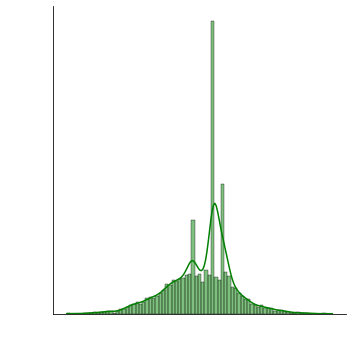

In [23]:
col = 'TotalSpent'
plt.figure(figsize=(12,8))
sns.displot(data=combined, x=col, color='g', kde=True)
plt.show()

In [24]:
col_bool = ['CryoSleep', 'VIP']

# correct dtypes of boolean columns from object to bool then to int
for col in col_bool:
    combined[col] = combined[col].astype(bool).astype(int)

In [25]:
# convert category columns to numerical/binary
combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12970 entries, 0 to 4276
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    12970 non-null  object 
 1   CryoSleep     12970 non-null  int64  
 2   Destination   12970 non-null  object 
 3   Age           12970 non-null  float64
 4   VIP           12970 non-null  int64  
 5   RoomService   12970 non-null  float64
 6   FoodCourt     12970 non-null  float64
 7   ShoppingMall  12970 non-null  float64
 8   Spa           12970 non-null  float64
 9   VRDeck        12970 non-null  float64
 10  Group         12970 non-null  object 
 11  deck          12970 non-null  object 
 12  cabin_num     12970 non-null  int64  
 13  side          12970 non-null  object 
 14  TotalSpent    12970 non-null  float64
dtypes: float64(7), int64(3), object(5)
memory usage: 1.6+ MB


In [26]:
# one hot encoding
combined = pd.get_dummies(combined, columns=['HomePlanet', 'Destination', 'deck', 'side'])

# shouldn't be, but for now, let's...maybe this does make sense after all
combined['Group'] = combined['Group'].astype('int')

In [27]:
# change dtypes to int
combined.iloc[:, -16:] = combined.iloc[:, -16:].astype(int)

In [28]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12970 entries, 0 to 4276
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CryoSleep                  12970 non-null  int64  
 1   Age                        12970 non-null  float64
 2   VIP                        12970 non-null  int64  
 3   RoomService                12970 non-null  float64
 4   FoodCourt                  12970 non-null  float64
 5   ShoppingMall               12970 non-null  float64
 6   Spa                        12970 non-null  float64
 7   VRDeck                     12970 non-null  float64
 8   Group                      12970 non-null  int64  
 9   cabin_num                  12970 non-null  int64  
 10  TotalSpent                 12970 non-null  float64
 11  HomePlanet_Earth           12970 non-null  int64  
 12  HomePlanet_Europa          12970 non-null  int64  
 13  HomePlanet_Mars            12970 non-null  int6

In [29]:
# saving a combined copy
combinedCopy = combined.copy(deep=True)

In [30]:
combined = combinedCopy.copy(deep=True)

Min-max Normalization

In [33]:
def min_max_norm(col):
    min_val = col.min()
    max_val = col.max()
    
    return (col-min_val) / (max_val - min_val)

combined = combined.apply(min_max_norm)

### Model design

In [36]:
train = combined.iloc[:train_id.shape[0]]
test = combined.iloc[-test_id.shape[0]:]
train[target] = train_target
print('Train shape', train.shape)
print('Test shape', test.shape)

Train shape (8693, 28)
Test shape (4277, 27)


/var/folders/3s/l2m1db5135751grhtk16_j200000gn/T/ipykernel_20543/2658725243.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[target] = train_target


In [37]:
# let's split train data into train/test
def train_test_split(data, test_ratio=0.3):
    test_indices = np.random.rand(data.shape[0]) < test_ratio
    return data[~test_indices], data[test_indices]
train_data, test_data = train_test_split(train)
print('{} samples in training, {} samples in testing data'.format(train_data.shape[0], 
                                                            test_data.shape[0]))

6075 samples in training, 2618 samples in testing data


In [38]:
train_data

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Group,cabin_num,TotalSpent,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,deck_A,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G,deck_T,side_P,side_S,Transported
1,0.0,0.684687,0.0,0.451438,0.167483,0.273702,0.602395,0.331287,0.000108,0.000000,0.276838,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1
2,0.0,0.917458,1.0,0.348215,0.779340,0.557632,0.870768,0.342498,0.000216,0.000000,0.643357,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
3,0.0,0.768042,0.0,0.348215,0.672723,0.557632,0.795530,0.486763,0.000216,0.000000,0.630095,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
5,0.0,0.844027,0.0,0.515354,0.571194,0.490608,0.534488,0.513321,0.000431,0.000000,0.547546,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1
6,0.0,0.705550,0.0,0.345625,0.691642,0.073965,0.514345,0.505796,0.000539,0.001056,0.385912,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8687,0.0,0.743001,0.0,0.000000,0.768042,0.501582,0.043486,0.543610,0.999461,0.051214,0.301321,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
8689,1.0,0.610292,0.0,0.515354,0.452702,0.490608,0.433614,0.513321,0.999784,0.791447,0.473066,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0
8690,0.0,0.705550,0.0,0.590200,0.539814,0.730117,0.000000,0.505796,0.999892,0.791975,0.459892,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1
8691,0.0,0.759949,0.0,0.467627,0.651786,0.461422,0.555138,0.786206,1.000000,0.321014,0.649080,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0


In [39]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6075 entries, 1 to 8692
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CryoSleep                  6075 non-null   float64
 1   Age                        6075 non-null   float64
 2   VIP                        6075 non-null   float64
 3   RoomService                6075 non-null   float64
 4   FoodCourt                  6075 non-null   float64
 5   ShoppingMall               6075 non-null   float64
 6   Spa                        6075 non-null   float64
 7   VRDeck                     6075 non-null   float64
 8   Group                      6075 non-null   float64
 9   cabin_num                  6075 non-null   float64
 10  TotalSpent                 6075 non-null   float64
 11  HomePlanet_Earth           6075 non-null   float64
 12  HomePlanet_Europa          6075 non-null   float64
 13  HomePlanet_Mars            6075 non-null   float

Model: Logistic Regression

In [ ]:
lr = LogisticRegression(max_iter=10000)
lr.fit(train_data.iloc[:, :-1], train_data[target])

In [ ]:
prediction = lr.predict(test_data.iloc[:, :-1])

In [ ]:
accuracy = accuracy_score(test_data[target], prediction)
print('Accuracy of {}'.format(accuracy))

Model: SVM (takes a while to run this though)

In [ ]:
# param_grid = {
#     'C': [0.1, 1, 10], # regularization parameter
#     'kernel': ['linear', 'rbf'], # kernel type
#     'gamma': [0.1, 1, 10] # kernel coefficient
# }

# svm = SVC()
# grid_search = GridSearchCV(svm, param_grid, cv=5)
# grid_search.fit(train_data.iloc[:, :-1], train_data[target])

# grid_search.best_params_

Model: TFDF

In [ ]:
# convert these to tensorflow datasets
train_data = tfdf.keras.pd_dataframe_to_tf_dataset(train_data, label=target)
test_data = tfdf.keras.pd_dataframe_to_tf_dataset(test_data, label=target)

In [ ]:
rf = tfdf.keras.RandomForestModel()
rf.fit(train_data)

In [ ]:
rf.summary()

In [ ]:
rf.compile(metrics=['accuracy'])
evaluation = rf.evaluate(test_data, return_dict=True)
display(evaluation)

In [ ]:
# tfdf.model_plotter.plot_model_in_colab(rf, tree_idx=0, max_depth=3)

Prediction

In [ ]:
test = tfdf.keras.pd_dataframe_to_tf_dataset(test)
predictions = rf.predict(test)
output = pd.DataFrame({'PassengerId': test_id, 'Transported': predictions.squeeze()})
# convert to boolean
output[target] = (output[target] >= 0.5)

In [ ]:
output.info()

In [ ]:
output.to_csv('data/sample_submission.csv', index=False)

Model : FNN  
Feedforwrad Neural Network

In [53]:
# can optimize following two
layer_size = 8
neuron_size = 64

layer_activation = 'relu'
output_activation = 'sigmoid'

# based on data
feature_size = train_data.shape[1]-1 # -1 cause target column
target_class_count = len(train_data[target].unique())-1 # cause binary, 0 doesn't count

model = keras.Sequential([
    keras.layers.Dense(layer_size, activation=layer_activation, 
                      input_shape=(feature_size,)),
    keras.layers.Dense(neuron_size, activation=layer_activation),
    keras.layers.Dense(target_class_count, activation=output_activation)
])

# optimizer options: SGD, Adam, RMSprop, Adagrad, Adadelta, Nadam, Ftrl
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

model.compile(optimizer=optimizer, loss='binary_crossentropy',
             metrics=['accuracy'])

In [54]:
epoch_size = 1000
batch_size = 128
history = model.fit(train_data.drop(columns=target), train_data[target], 
                    epochs = epoch_size, batch_size=batch_size,
                    validation_data=(test_data.drop(columns=target), test_data[target]))

Epoch 1/1000
48/48 [==============================] - 0s 4ms/step - loss: 0.6973 - accuracy: 0.5009 - val_loss: 0.6946 - val_accuracy: 0.5149
Epoch 2/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.6914 - accuracy: 0.5218 - val_loss: 0.6896 - val_accuracy: 0.5413
Epoch 3/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.6878 - accuracy: 0.5470 - val_loss: 0.6861 - val_accuracy: 0.5649
Epoch 4/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.6851 - accuracy: 0.5751 - val_loss: 0.6832 - val_accuracy: 0.5924
Epoch 5/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.6827 - accuracy: 0.5891 - val_loss: 0.6806 - val_accuracy: 0.5970
Epoch 6/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.6803 - accuracy: 0.5980 - val_loss: 0.6781 - val_accuracy: 0.6058
Epoch 7/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.6779 - accuracy: 0.6076 - val_loss: 0.6756 - val_accuracy: 0.6138
Epoch 

48/48 [==============================] - 0s 2ms/step - loss: 0.5436 - accuracy: 0.7249 - val_loss: 0.5451 - val_accuracy: 0.7181
Epoch 59/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.5428 - accuracy: 0.7263 - val_loss: 0.5443 - val_accuracy: 0.7189
Epoch 60/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.5420 - accuracy: 0.7264 - val_loss: 0.5436 - val_accuracy: 0.7193
Epoch 61/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.5413 - accuracy: 0.7266 - val_loss: 0.5429 - val_accuracy: 0.7189
Epoch 62/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.5405 - accuracy: 0.7291 - val_loss: 0.5421 - val_accuracy: 0.7200
Epoch 63/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.5398 - accuracy: 0.7264 - val_loss: 0.5415 - val_accuracy: 0.7204
Epoch 64/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.5391 - accuracy: 0.7291 - val_loss: 0.5407 - val_accuracy: 0.7200
Epoch 65/1000

48/48 [==============================] - 0s 2ms/step - loss: 0.5118 - accuracy: 0.7435 - val_loss: 0.5148 - val_accuracy: 0.7383
Epoch 116/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.5113 - accuracy: 0.7439 - val_loss: 0.5146 - val_accuracy: 0.7376
Epoch 117/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.5110 - accuracy: 0.7439 - val_loss: 0.5140 - val_accuracy: 0.7391
Epoch 118/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.5106 - accuracy: 0.7439 - val_loss: 0.5138 - val_accuracy: 0.7372
Epoch 119/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.5102 - accuracy: 0.7430 - val_loss: 0.5133 - val_accuracy: 0.7395
Epoch 120/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.5097 - accuracy: 0.7449 - val_loss: 0.5131 - val_accuracy: 0.7372
Epoch 121/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.5094 - accuracy: 0.7455 - val_loss: 0.5127 - val_accuracy: 0.7422
Epoch 1

Epoch 172/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4953 - accuracy: 0.7505 - val_loss: 0.5004 - val_accuracy: 0.7426
Epoch 173/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4952 - accuracy: 0.7509 - val_loss: 0.5003 - val_accuracy: 0.7426
Epoch 174/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4949 - accuracy: 0.7513 - val_loss: 0.5004 - val_accuracy: 0.7448
Epoch 175/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4947 - accuracy: 0.7516 - val_loss: 0.5004 - val_accuracy: 0.7445
Epoch 176/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4947 - accuracy: 0.7508 - val_loss: 0.4999 - val_accuracy: 0.7441
Epoch 177/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4944 - accuracy: 0.7500 - val_loss: 0.5001 - val_accuracy: 0.7456
Epoch 178/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4943 - accuracy: 0.7511 - val_loss: 0.4998 - val_accuracy:

Epoch 229/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4880 - accuracy: 0.7528 - val_loss: 0.4959 - val_accuracy: 0.7475
Epoch 230/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4880 - accuracy: 0.7531 - val_loss: 0.4957 - val_accuracy: 0.7468
Epoch 231/1000
48/48 [==============================] - 0s 1ms/step - loss: 0.4880 - accuracy: 0.7524 - val_loss: 0.4957 - val_accuracy: 0.7452
Epoch 232/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4878 - accuracy: 0.7528 - val_loss: 0.4956 - val_accuracy: 0.7471
Epoch 233/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4878 - accuracy: 0.7529 - val_loss: 0.4955 - val_accuracy: 0.7468
Epoch 234/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4876 - accuracy: 0.7537 - val_loss: 0.4955 - val_accuracy: 0.7475
Epoch 235/1000
48/48 [==============================] - 0s 1ms/step - loss: 0.4875 - accuracy: 0.7516 - val_loss: 0.4956 - val_accuracy:

Epoch 286/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4842 - accuracy: 0.7552 - val_loss: 0.4935 - val_accuracy: 0.7506
Epoch 287/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4840 - accuracy: 0.7559 - val_loss: 0.4934 - val_accuracy: 0.7483
Epoch 288/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4841 - accuracy: 0.7559 - val_loss: 0.4935 - val_accuracy: 0.7506
Epoch 289/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4840 - accuracy: 0.7551 - val_loss: 0.4935 - val_accuracy: 0.7490
Epoch 290/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4838 - accuracy: 0.7552 - val_loss: 0.4936 - val_accuracy: 0.7494
Epoch 291/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4839 - accuracy: 0.7551 - val_loss: 0.4935 - val_accuracy: 0.7494
Epoch 292/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4837 - accuracy: 0.7559 - val_loss: 0.4933 - val_accuracy:

Epoch 343/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4813 - accuracy: 0.7564 - val_loss: 0.4919 - val_accuracy: 0.7498
Epoch 344/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4810 - accuracy: 0.7582 - val_loss: 0.4918 - val_accuracy: 0.7483
Epoch 345/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4809 - accuracy: 0.7590 - val_loss: 0.4918 - val_accuracy: 0.7502
Epoch 346/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4809 - accuracy: 0.7577 - val_loss: 0.4917 - val_accuracy: 0.7475
Epoch 347/1000
48/48 [==============================] - 0s 1ms/step - loss: 0.4810 - accuracy: 0.7590 - val_loss: 0.4920 - val_accuracy: 0.7525
Epoch 348/1000
48/48 [==============================] - 0s 1ms/step - loss: 0.4809 - accuracy: 0.7598 - val_loss: 0.4916 - val_accuracy: 0.7510
Epoch 349/1000
48/48 [==============================] - 0s 1ms/step - loss: 0.4809 - accuracy: 0.7582 - val_loss: 0.4915 - val_accuracy:

Epoch 400/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4787 - accuracy: 0.7607 - val_loss: 0.4904 - val_accuracy: 0.7502
Epoch 401/1000
48/48 [==============================] - 0s 1ms/step - loss: 0.4784 - accuracy: 0.7608 - val_loss: 0.4906 - val_accuracy: 0.7506
Epoch 402/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4785 - accuracy: 0.7597 - val_loss: 0.4905 - val_accuracy: 0.7494
Epoch 403/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4784 - accuracy: 0.7605 - val_loss: 0.4903 - val_accuracy: 0.7506
Epoch 404/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4786 - accuracy: 0.7595 - val_loss: 0.4905 - val_accuracy: 0.7502
Epoch 405/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4784 - accuracy: 0.7616 - val_loss: 0.4904 - val_accuracy: 0.7494
Epoch 406/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4783 - accuracy: 0.7602 - val_loss: 0.4903 - val_accuracy:

Epoch 457/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4764 - accuracy: 0.7615 - val_loss: 0.4894 - val_accuracy: 0.7502
Epoch 458/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4765 - accuracy: 0.7618 - val_loss: 0.4894 - val_accuracy: 0.7490
Epoch 459/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4760 - accuracy: 0.7610 - val_loss: 0.4895 - val_accuracy: 0.7479
Epoch 460/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4761 - accuracy: 0.7607 - val_loss: 0.4903 - val_accuracy: 0.7510
Epoch 461/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4764 - accuracy: 0.7605 - val_loss: 0.4896 - val_accuracy: 0.7494
Epoch 462/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4762 - accuracy: 0.7592 - val_loss: 0.4897 - val_accuracy: 0.7494
Epoch 463/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4761 - accuracy: 0.7603 - val_loss: 0.4894 - val_accuracy:

Epoch 514/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4745 - accuracy: 0.7615 - val_loss: 0.4884 - val_accuracy: 0.7487
Epoch 515/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4744 - accuracy: 0.7636 - val_loss: 0.4883 - val_accuracy: 0.7494
Epoch 516/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4744 - accuracy: 0.7638 - val_loss: 0.4884 - val_accuracy: 0.7479
Epoch 517/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4742 - accuracy: 0.7625 - val_loss: 0.4888 - val_accuracy: 0.7536
Epoch 518/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4743 - accuracy: 0.7623 - val_loss: 0.4885 - val_accuracy: 0.7471
Epoch 519/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4743 - accuracy: 0.7630 - val_loss: 0.4884 - val_accuracy: 0.7483
Epoch 520/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4741 - accuracy: 0.7633 - val_loss: 0.4883 - val_accuracy:

Epoch 571/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4727 - accuracy: 0.7635 - val_loss: 0.4875 - val_accuracy: 0.7548
Epoch 572/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4726 - accuracy: 0.7653 - val_loss: 0.4873 - val_accuracy: 0.7494
Epoch 573/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4727 - accuracy: 0.7656 - val_loss: 0.4875 - val_accuracy: 0.7544
Epoch 574/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4726 - accuracy: 0.7654 - val_loss: 0.4880 - val_accuracy: 0.7536
Epoch 575/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4725 - accuracy: 0.7641 - val_loss: 0.4871 - val_accuracy: 0.7483
Epoch 576/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4725 - accuracy: 0.7640 - val_loss: 0.4877 - val_accuracy: 0.7544
Epoch 577/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4726 - accuracy: 0.7640 - val_loss: 0.4871 - val_accuracy:

Epoch 628/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4709 - accuracy: 0.7684 - val_loss: 0.4861 - val_accuracy: 0.7487
Epoch 629/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4711 - accuracy: 0.7667 - val_loss: 0.4862 - val_accuracy: 0.7525
Epoch 630/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4709 - accuracy: 0.7682 - val_loss: 0.4861 - val_accuracy: 0.7532
Epoch 631/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4709 - accuracy: 0.7656 - val_loss: 0.4863 - val_accuracy: 0.7525
Epoch 632/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4707 - accuracy: 0.7676 - val_loss: 0.4859 - val_accuracy: 0.7494
Epoch 633/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4708 - accuracy: 0.7644 - val_loss: 0.4860 - val_accuracy: 0.7525
Epoch 634/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4705 - accuracy: 0.7679 - val_loss: 0.4860 - val_accuracy:

Epoch 685/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4696 - accuracy: 0.7691 - val_loss: 0.4854 - val_accuracy: 0.7510
Epoch 686/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4693 - accuracy: 0.7682 - val_loss: 0.4851 - val_accuracy: 0.7510
Epoch 687/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4693 - accuracy: 0.7674 - val_loss: 0.4851 - val_accuracy: 0.7510
Epoch 688/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4693 - accuracy: 0.7700 - val_loss: 0.4851 - val_accuracy: 0.7510
Epoch 689/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4692 - accuracy: 0.7691 - val_loss: 0.4853 - val_accuracy: 0.7513
Epoch 690/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4692 - accuracy: 0.7669 - val_loss: 0.4856 - val_accuracy: 0.7513
Epoch 691/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4693 - accuracy: 0.7681 - val_loss: 0.4857 - val_accuracy:

Epoch 742/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4680 - accuracy: 0.7686 - val_loss: 0.4848 - val_accuracy: 0.7513
Epoch 743/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4680 - accuracy: 0.7684 - val_loss: 0.4852 - val_accuracy: 0.7532
Epoch 744/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4680 - accuracy: 0.7684 - val_loss: 0.4842 - val_accuracy: 0.7529
Epoch 745/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4678 - accuracy: 0.7704 - val_loss: 0.4842 - val_accuracy: 0.7525
Epoch 746/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4678 - accuracy: 0.7700 - val_loss: 0.4842 - val_accuracy: 0.7525
Epoch 747/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4676 - accuracy: 0.7702 - val_loss: 0.4846 - val_accuracy: 0.7517
Epoch 748/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4678 - accuracy: 0.7694 - val_loss: 0.4846 - val_accuracy:

Epoch 799/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4667 - accuracy: 0.7707 - val_loss: 0.4839 - val_accuracy: 0.7544
Epoch 800/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4665 - accuracy: 0.7687 - val_loss: 0.4845 - val_accuracy: 0.7513
Epoch 801/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4667 - accuracy: 0.7695 - val_loss: 0.4842 - val_accuracy: 0.7536
Epoch 802/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4662 - accuracy: 0.7700 - val_loss: 0.4850 - val_accuracy: 0.7517
Epoch 803/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4667 - accuracy: 0.7686 - val_loss: 0.4841 - val_accuracy: 0.7513
Epoch 804/1000
48/48 [==============================] - 0s 1ms/step - loss: 0.4663 - accuracy: 0.7695 - val_loss: 0.4840 - val_accuracy: 0.7529
Epoch 805/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4665 - accuracy: 0.7699 - val_loss: 0.4843 - val_accuracy:

Epoch 856/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4654 - accuracy: 0.7699 - val_loss: 0.4838 - val_accuracy: 0.7532
Epoch 857/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4656 - accuracy: 0.7695 - val_loss: 0.4842 - val_accuracy: 0.7521
Epoch 858/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4656 - accuracy: 0.7695 - val_loss: 0.4839 - val_accuracy: 0.7544
Epoch 859/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4654 - accuracy: 0.7692 - val_loss: 0.4836 - val_accuracy: 0.7536
Epoch 860/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4653 - accuracy: 0.7694 - val_loss: 0.4840 - val_accuracy: 0.7536
Epoch 861/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4657 - accuracy: 0.7689 - val_loss: 0.4839 - val_accuracy: 0.7517
Epoch 862/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4653 - accuracy: 0.7687 - val_loss: 0.4837 - val_accuracy:

Epoch 913/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4650 - accuracy: 0.7691 - val_loss: 0.4839 - val_accuracy: 0.7525
Epoch 914/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4647 - accuracy: 0.7684 - val_loss: 0.4836 - val_accuracy: 0.7532
Epoch 915/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4648 - accuracy: 0.7691 - val_loss: 0.4839 - val_accuracy: 0.7574
Epoch 916/1000
48/48 [==============================] - 0s 3ms/step - loss: 0.4648 - accuracy: 0.7699 - val_loss: 0.4834 - val_accuracy: 0.7529
Epoch 917/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4645 - accuracy: 0.7714 - val_loss: 0.4834 - val_accuracy: 0.7525
Epoch 918/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4647 - accuracy: 0.7689 - val_loss: 0.4837 - val_accuracy: 0.7517
Epoch 919/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4646 - accuracy: 0.7687 - val_loss: 0.4836 - val_accuracy:

Epoch 970/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4639 - accuracy: 0.7677 - val_loss: 0.4840 - val_accuracy: 0.7529
Epoch 971/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4638 - accuracy: 0.7691 - val_loss: 0.4842 - val_accuracy: 0.7548
Epoch 972/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4642 - accuracy: 0.7667 - val_loss: 0.4837 - val_accuracy: 0.7536
Epoch 973/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4640 - accuracy: 0.7677 - val_loss: 0.4839 - val_accuracy: 0.7521
Epoch 974/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4639 - accuracy: 0.7692 - val_loss: 0.4840 - val_accuracy: 0.7521
Epoch 975/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4639 - accuracy: 0.7681 - val_loss: 0.4838 - val_accuracy: 0.7532
Epoch 976/1000
48/48 [==============================] - 0s 2ms/step - loss: 0.4639 - accuracy: 0.7687 - val_loss: 0.4836 - val_accuracy:

In [55]:
history_df = pd.DataFrame()

history_df['epoch_round'] = [num+1 for num in range(epoch_size)]
history_df['training_loss'] = history.history['loss']
history_df['training_accuracy'] = history.history['accuracy']
history_df['val_loss'] = history.history['val_loss']
history_df['val_accuracy'] = history.history['val_accuracy']

# helps get rid of the initial outliers for visuals
history_df = history_df.loc[history_df['epoch_round']>5]

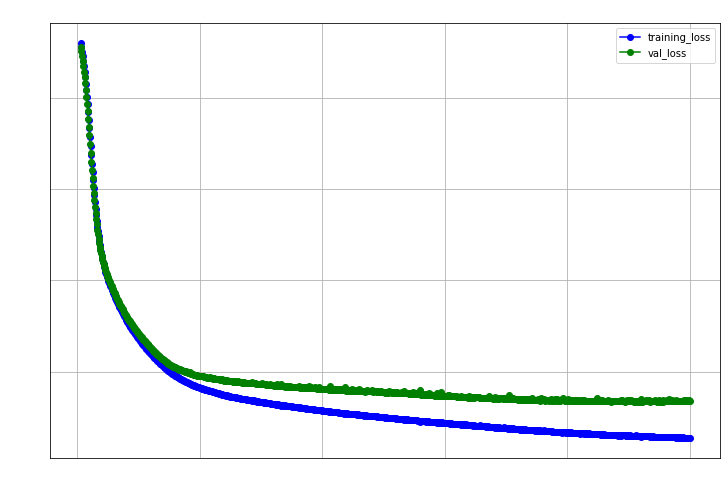

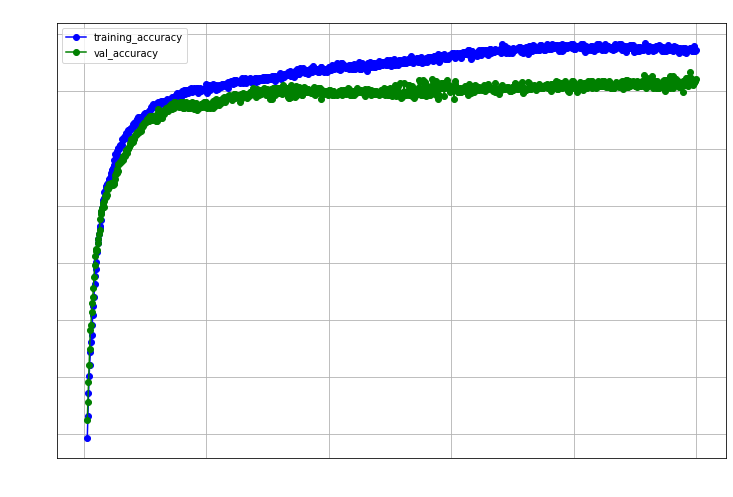

In [56]:
plt.figure(figsize=(12,8))
plt.grid(True)

plt.plot(history_df['epoch_round'], history_df['training_loss'], marker='o',
        linestyle='-', color='blue', label='training_loss')
plt.plot(history_df['epoch_round'], history_df['val_loss'], marker='o',
        linestyle='-', color='green', label='val_loss')

plt.xlabel('epoch_round')
plt.ylabel('loss')
plt.title('Loss visualized')

legend = plt.legend()

# Set the legend text color to white
for text in legend.get_texts():
    text.set_color('black')
    
plt.show()

plt.figure(figsize=(12,8))
plt.grid(True)

plt.plot(history_df['epoch_round'], history_df['training_accuracy'], marker='o',
        linestyle='-', color='blue', label='training_accuracy')
plt.plot(history_df['epoch_round'], history_df['val_accuracy'], marker='o',
        linestyle='-', color='green', label='val_accuracy')

plt.xlabel('epoch_round')
plt.ylabel('accuracy')
plt.title('Accuracy visualized')

legend = plt.legend()

# Set the legend text color to white
for text in legend.get_texts():
    text.set_color('black')
    
plt.show()